<a href="https://colab.research.google.com/github/MathiLogha/NextWordPredictor/blob/main/next_word_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import the required libraries:**bold text**

We use TensorFlow with Keras for our model building. We can import the LSTM model from Keras and use it.  For different NLP tasks, we can use the NLTK library.


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 462 kB 9.9 MB/s 


In [ ]:
!pip install keras
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**2. Read the dataset:**


We can check the length of the corpus by using the len function on text after reading and converting everything to lower case to avoid duplication of words.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 1661-0.txt to 1661-0.txt


In [ ]:
text = open('1661-0.txt', encoding='utf-8').read().lower()
print('corpus length:', len(text))

corpus length: 581941


**3.  Using tokenizers:**


The tokenizers are required so that we can split into each word and store them.

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

**4. Getting unique words:**


We get all the unique words and we require a dictionary with each word in the data within the list of unique words as the key and its significant portions as value.

In [ ]:
import numpy as np
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

**5. Feature Engineering:**



Feature engineering will make the words into numerical representation so that it is easy to process them.

In [ ]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


**6. Storing features and labels:**


X will be used to get the features and Y to get the labels associated with them.

In [ ]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)

In [ ]:
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [ ]:
print(X[0][0])

[False False False ... False False False]


**7. Building our model:**


We can see that we have built an LSTM model and used a softmax activation at the end to get few specific words predicted by the model.

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

8. Model training:
**bold text**

The model training uses RMSprop as the optimizer with a learning rate of 0.02 and uses categorical cross-entropy for loss function. With a batch size of 128 and a split of 0.5, we train our model.

In [ ]:
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


811/811 [==============================] - 273s 333ms/step - loss: 6.0208 - accuracy: 0.1067 - val_loss: 7.0500 - val_accuracy: 0.0963
Epoch 2/20
811/811 [==============================] - 258s 319ms/step - loss: 5.7821 - accuracy: 0.1466 - val_loss: 7.9404 - val_accuracy: 0.1073
Epoch 3/20
811/811 [==============================] - 258s 318ms/step - loss: 5.7458 - accuracy: 0.1762 - val_loss: 8.0355 - val_accuracy: 0.1071
Epoch 4/20
811/811 [==============================] - 257s 317ms/step - loss: 5.4252 - accuracy: 0.2105 - val_loss: 8.3428 - val_accuracy: 0.1031
Epoch 5/20
811/811 [==============================] - 261s 322ms/step - loss: 5.1023 - accuracy: 0.2485 - val_loss: 8.2440 - val_accuracy: 0.0919
Epoch 6/20
811/811 [==============================] - 261s 321ms/step - loss: 4.7979 - accuracy: 0.2884 - val_loss: 8.6138 - val_accuracy: 0.0864
Epoch 7/20
811/811 [==============================] - 262s 323ms/step - loss: 4.5018 - accuracy: 0.3283 - val_loss: 8.8038 - val_accura

**8. Saving model:**


The model is saved using the save function and loaded.

In [ ]:
import pickle
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

**9. Evaluating the model:**


We can see the results of the models on evaluation.

plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
model accuracy
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
model loss | predict next word LSTM

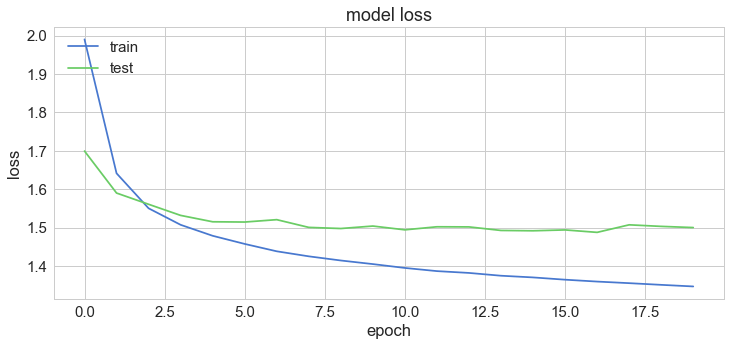


**10. Testing next word:**



These functions will help us to predict the next few words when we provide a sentence.

In [ ]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
import heapq
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [ ]:
q=input()
print("correct sentence: ",q)

lets have fun and
correct sentence:  lets have fun and


In [ ]:
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
l = predict_completions(seq, 5)
print("next possible words: ", l )

Sequence:  lets have fun and
